In [ ]:
import sys
import time
import random
from os.path import exists
from typing import *

# Common data science imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.cluster import KMeans

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from tqdm import tqdm, notebook as tqdm_notebook

# GPyTorch and linear_operator imports
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.constraints import *
import linear_operator
from linear_operator.settings import max_cholesky_size
from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.utils.cholesky import psd_safe_cholesky

# Custom soft GP and MLL imports
from gp.soft_gp.soft_gp import SoftGP
from gp.soft_gp.mll import HutchinsonPseudoLoss
from linear_solver.cg import linear_cg

# Data analysis and UCI dataset

# Utility functions for dataset handling
from gp.util import flatten_dataset, split_dataset, filter_param

# Experiment tracking
import wandb

# System path adjustments
sys.path.append("../")

In [ ]:
def eval_gp(model, test_dataset: Dataset, device="cuda:0") -> float:
    preds = []
    neg_mlls = []
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=1)
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds += [(model.pred(x_batch) - y_batch).detach().cpu()**2]
        neg_mlls += [-model.mll(x_batch, y_batch).detach().cpu()]
    rmse = torch.sqrt(torch.sum(torch.cat(preds)) / len(test_dataset)).item()
    neg_mll = torch.sum(torch.tensor(neg_mlls))
            
    print("RMSE:", rmse, "NEG_MLL", neg_mll.item(), "NOISE", model.noise.cpu().item(), "LENGTHSCALE", model.get_lengthscale(), "OUTPUTSCALE", model.get_outputscale())# "T",model.T)
    
    return {
        "rmse": rmse,
        "nll": neg_mll,
    }   
   

In [30]:
#==================Dataset============================
from data.get_uci import ElevatorsDataset,PoleteleDataset
# # dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/elevators/data.csv")
dataset = PoleteleDataset("../data/uci_datasets/uci_datasets/pol/data.csv")

# dataset = CTSlicesDataset("../data/uci_datasets/uci_datasets/slice/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=9/10, #TODO change to real vals 
    val_frac=0/10
)

def plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, tolerance_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    epochs_range = range(1, epochs + 1)

    # Plot RMSE per Epoch for each model (baseline + CG tolerances)
    for i in range(len(tolerance_values)):
        if i == 0:
            # First entry is the baseline
            axes[0].plot(epochs_range, all_mean_rmse[i], label='Baseline (solve)')
        else:
            # Entries after the baseline correspond to CG tolerances
            tol = tolerance_values[i]
            axes[0].plot(epochs_range, all_mean_rmse[i], label=f'CG Tolerance {tol}')
        
        # Fill between the RMSE values for standard deviation
        axes[0].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             [m + s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             alpha=0.3)

    axes[0].set_title('RMSE per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()

    # Plot Training Time per Epoch for each model (baseline + CG tolerances)
    for i in range(len(tolerance_values)):
        if i == 0:
            # First entry is the baseline
            axes[1].plot(epochs_range, all_mean_runtimes[i], label='Baseline (solve)')
        else:
            # Entries after the baseline correspond to CG tolerances
            tol = tolerance_values[i]
            axes[1].plot(epochs_range, all_mean_runtimes[i], label=f'CG Tolerance {tol}')
        
        # Fill between the runtime values for standard deviation
        axes[1].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             [m + s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             alpha=0.3)

    axes[1].set_title('Training Time per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Time (s)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def train_gp(GP_class, inducing_points, test_dataset, train_features, train_labels, epochs, device, dtype, model_config=None):
    model_config = model_config or {}
    kernel = RBFKernel().to(device=device, dtype=dtype)
    learn_noise = model_config.get("learn_noise", False)
    lr = model_config.get("learning_rate", 0.01)
    batch_size = model_config.get("batch_size", 1024)

    model = GP_class(
        kernel,
        inducing_points,
        noise=model_config.get("noise", 1e-3),
        learn_noise=learn_noise,
        use_scale=model_config.get("use_scale", True),
        dtype=dtype,
        max_cg_iter=1000,
        solver=model_config.get("solver", "solve"),
        mll_approx=model_config.get("mll_approx", "hutchinson"),
        fit_chunk_size=model_config.get("fit_chunk_size", 1024),
        use_qr=model_config.get("use_qr", True)
        
    )


    epoch_runtimes = []
    epoch_rmse = []

    # pbar = tqdm(range(epochs), desc="Optimizing MLL")
    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    def train_model():
        #==================Train============================
        for _ in tqdm(range(epochs)):
            print("training current epoch")
            epoch_start_time = time.time()

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)), gpytorch.settings.max_preconditioner_size(15):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mll.backward()
                optimizer.step()
                # pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
                # pbar.set_postfix(MLL=f"{-neg_mll.item()}")
            model.fit(train_features, train_labels)
            epoch_end_time = time.time()
            epoch_runtimes.append(epoch_end_time - epoch_start_time)

            #==================Evaluate============================
            print("Running eval")
            eval_results = eval_gp(model, test_dataset, device=device)
            epoch_rmse.append(eval_results['rmse'])
            print("eval finished")    
    train_model()
    return epoch_rmse, epoch_runtimes

SIZE (15000, 27)


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. You have {torch.cuda.device_count()} GPU(s).")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. No GPU detected.")

In [31]:
def benchmark( train_dataset, test_dataset, epochs=2, seed=42, N=3):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_inducing = 512
    dtype = torch.float32
    device = "cpu"
    
    all_mean_rmse = []
    all_mean_runtimes = []
    all_std_rmse = []
    all_std_runtimes = []

    #==================Inducing Points============================
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)

    # List of model configurations
    baseline_config = {
        "solver": "solve",  # Baseline uses solve
    }
    
    # CG configurations with different tolerances
    cg_configs = [
        {"solver": "cg", "cg_tolerance": 1e-4},
        {"solver": "cg", "cg_tolerance": 1e-3},
        {"solver": "cg", "cg_tolerance": 1e-2},
        {"solver": "cg", "cg_tolerance": 1e-1},
    ]

    # First run the baseline model
    all_runs_rmse = []
    all_runs_runtimes = []

    print("Running baseline model with 'solve' solver")
    for run in range(N):
        epoch_rmse, epoch_runtimes = train_gp(
            SoftGP,
            inducing_points.clone(),
            test_dataset,
            train_features,
            train_labels,
            epochs,
            device,
            dtype,
            model_config=baseline_config  # Pass baseline config
        )
        all_runs_rmse.append(epoch_rmse)
        all_runs_runtimes.append(epoch_runtimes)

    # Calculate mean and std deviation across the N runs for the baseline
    mean_rmse = np.mean(all_runs_rmse, axis=0)
    std_rmse = np.std(all_runs_rmse, axis=0)
    mean_runtimes = np.mean(all_runs_runtimes, axis=0)
    std_runtimes = np.std(all_runs_runtimes, axis=0)

    all_mean_rmse.append(mean_rmse)
    all_mean_runtimes.append(mean_runtimes)
    all_std_rmse.append(std_rmse)
    all_std_runtimes.append(std_runtimes)

    # Now run the CG models with varying CG tolerances
    for i, cg_config in enumerate(cg_configs):
        all_runs_rmse = []
        all_runs_runtimes = []

        print(f"Running CG model with tolerance {cg_config['cg_tolerance']}")
        for run in range(N):
            epoch_rmse, epoch_runtimes = train_gp(
                SoftGP,
                inducing_points.clone(),
                test_dataset,
                train_features,
                train_labels,
                epochs,
                device,
                dtype,
                model_config=cg_config  # Pass CG config with the current tolerance
            )
            all_runs_rmse.append(epoch_rmse)
            all_runs_runtimes.append(epoch_runtimes)

        # Calculate mean and std deviation across the N runs for each CG tolerance
        mean_rmse = np.mean(all_runs_rmse, axis=0)
        std_rmse = np.std(all_runs_rmse, axis=0)
        mean_runtimes = np.mean(all_runs_runtimes, axis=0)
        std_runtimes = np.std(all_runs_runtimes, axis=0)

        all_mean_rmse.append(mean_rmse)
        all_mean_runtimes.append(mean_runtimes)
        all_std_rmse.append(std_rmse)
        all_std_runtimes.append(std_runtimes)

    return all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes

#==================Benchmark============================

epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark( train_dataset, test_dataset, epochs=epochs, seed=6535, N=N)


  0%|          | 0/2 [00:00<?, ?it/s]

Running baseline model with 'solve' solver
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:24,  7.84s/it]

RMSE: 0.2614544630050659 NEG_MLL -1436.3760986328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6312]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7650, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:15<06:07,  7.67s/it]

RMSE: 0.2442433089017868 NEG_MLL -1397.73291015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6077]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8356, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:55,  7.57s/it]

RMSE: 0.23585297167301178 NEG_MLL -1317.095947265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6181]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9091, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:30<05:46,  7.54s/it]

RMSE: 0.230150043964386 NEG_MLL -1235.3677978515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6392]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9846, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:38,  7.52s/it]

RMSE: 0.22566884756088257 NEG_MLL -1155.1568603515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6604]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0607, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:45<05:28,  7.47s/it]

RMSE: 0.22175216674804688 NEG_MLL -1080.593994140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6732]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1394, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:52<05:21,  7.47s/it]

RMSE: 0.21882601082324982 NEG_MLL -1026.631103515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6731]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2163, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [01:00<05:13,  7.46s/it]

RMSE: 0.21716952323913574 NEG_MLL -979.3330688476562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6706]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2925, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:07<05:05,  7.45s/it]

RMSE: 0.21453391015529633 NEG_MLL -934.3318481445312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6670]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3677, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:14<04:58,  7.45s/it]

RMSE: 0.2128363698720932 NEG_MLL -903.1907348632812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6601]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4445, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:22<04:49,  7.44s/it]

RMSE: 0.21173138916492462 NEG_MLL -872.822509765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6475]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5217, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:29<04:42,  7.43s/it]

RMSE: 0.20966270565986633 NEG_MLL -844.6777954101562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6367]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5978, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:37<04:34,  7.42s/it]

RMSE: 0.20799735188484192 NEG_MLL -815.302001953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6281]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6739, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:44<04:27,  7.43s/it]

RMSE: 0.20672589540481567 NEG_MLL -793.2808837890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6191]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7501, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:52<04:19,  7.42s/it]

RMSE: 0.20611430704593658 NEG_MLL -763.6904296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6165]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8271, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:59<04:12,  7.42s/it]

RMSE: 0.20393815636634827 NEG_MLL -738.6549682617188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6089]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9035, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:06<04:05,  7.43s/it]

RMSE: 0.203328937292099 NEG_MLL -719.8291625976562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5981]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9793, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:14<03:57,  7.42s/it]

RMSE: 0.2017880082130432 NEG_MLL -702.6878662109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5872]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0534, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:21<03:49,  7.42s/it]

RMSE: 0.20165307819843292 NEG_MLL -684.2661743164062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5774]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1287, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:29<03:44,  7.48s/it]

RMSE: 0.2012503445148468 NEG_MLL -670.9166870117188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5702]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2023, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:36<03:37,  7.49s/it]

RMSE: 0.19970762729644775 NEG_MLL -652.2470092773438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5641]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2750, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:44<03:29,  7.49s/it]

RMSE: 0.19773893058300018 NEG_MLL -640.6031494140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5562]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3472, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:51<03:21,  7.47s/it]

RMSE: 0.19751083850860596 NEG_MLL -623.3554077148438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5493]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4199, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [02:59<03:13,  7.46s/it]

RMSE: 0.19683100283145905 NEG_MLL -612.770263671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5413]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4917, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:06<03:06,  7.47s/it]

RMSE: 0.195596843957901 NEG_MLL -602.39306640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5332]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5602, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:14<02:59,  7.46s/it]

RMSE: 0.19661563634872437 NEG_MLL -590.5967407226562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5261]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6291, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:21<02:51,  7.45s/it]

RMSE: 0.19442477822303772 NEG_MLL -576.064453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5191]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6975, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:29<02:43,  7.45s/it]

RMSE: 0.19412527978420258 NEG_MLL -566.0698852539062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5108]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7646, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:36<02:36,  7.44s/it]

RMSE: 0.19426770508289337 NEG_MLL -554.4302978515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5021]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8331, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:43<02:29,  7.46s/it]

RMSE: 0.19343528151512146 NEG_MLL -543.0498657226562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4949]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9007, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:51<02:21,  7.45s/it]

RMSE: 0.19225673377513885 NEG_MLL -534.1603393554688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4872]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9687, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [03:58<02:14,  7.45s/it]

RMSE: 0.1925838738679886 NEG_MLL -526.5601196289062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4797]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0349, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:06<02:06,  7.44s/it]

RMSE: 0.19202113151550293 NEG_MLL -517.2999877929688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4717]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0999, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:13<01:59,  7.44s/it]

RMSE: 0.19107598066329956 NEG_MLL -509.494140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4618]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1647, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:21<01:51,  7.44s/it]

RMSE: 0.1906023919582367 NEG_MLL -501.29449462890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4539]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2279, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:28<01:44,  7.48s/it]

RMSE: 0.18968182802200317 NEG_MLL -493.6050720214844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4456]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2909, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:36<01:37,  7.47s/it]

RMSE: 0.18986135721206665 NEG_MLL -488.0645751953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4362]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3533, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:43<01:29,  7.47s/it]

RMSE: 0.18955861032009125 NEG_MLL -480.65386962890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4281]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4152, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:51<01:21,  7.45s/it]

RMSE: 0.18828870356082916 NEG_MLL -473.30084228515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4202]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4774, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [04:58<01:14,  7.45s/it]

RMSE: 0.18833234906196594 NEG_MLL -467.91009521484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4109]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5397, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:06<01:07,  7.52s/it]

RMSE: 0.18832139670848846 NEG_MLL -458.9442138671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4036]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6021, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:13<01:00,  7.51s/it]

RMSE: 0.18801797926425934 NEG_MLL -453.0824890136719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3961]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6639, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:21<00:52,  7.49s/it]

RMSE: 0.18841615319252014 NEG_MLL -449.01165771484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3891]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7243, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:28<00:44,  7.48s/it]

RMSE: 0.18675296008586884 NEG_MLL -443.8829345703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3816]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7838, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:35<00:37,  7.47s/it]

RMSE: 0.1866207718849182 NEG_MLL -437.2402648925781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3755]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8432, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:43<00:29,  7.47s/it]

RMSE: 0.18746402859687805 NEG_MLL -432.1964111328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3705]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9027, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:50<00:22,  7.48s/it]

RMSE: 0.18575526773929596 NEG_MLL -426.15863037109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3664]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9616, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [05:58<00:14,  7.46s/it]

RMSE: 0.1863025426864624 NEG_MLL -420.737548828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3621]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0199, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:05<00:07,  7.47s/it]

RMSE: 0.18496471643447876 NEG_MLL -414.77886962890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3580]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0787, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:13<00:00,  7.47s/it]


RMSE: 0.18620023131370544 NEG_MLL -409.8123779296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3536]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.1385, grad_fn=<SoftplusBackward0>)
eval finished
Running CG model with tolerance 0.0001
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:10,  7.57s/it]

RMSE: 0.2646750211715698 NEG_MLL -1408.7314453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6327]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7643, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:15<06:02,  7.54s/it]

RMSE: 0.24717339873313904 NEG_MLL -1370.3809814453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6025]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8365, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:54,  7.54s/it]

RMSE: 0.2373730093240738 NEG_MLL -1304.01708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5909]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9114, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:30<05:46,  7.54s/it]

RMSE: 0.2322792410850525 NEG_MLL -1226.842041015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5925]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9887, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:39,  7.54s/it]

RMSE: 0.2290271371603012 NEG_MLL -1151.068603515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6024]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0651, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:45<05:31,  7.54s/it]

RMSE: 0.22593791782855988 NEG_MLL -1085.001220703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6166]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1408, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:52<05:25,  7.56s/it]

RMSE: 0.22286425530910492 NEG_MLL -1028.3720703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6289]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2154, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [01:00<05:17,  7.56s/it]

RMSE: 0.22067248821258545 NEG_MLL -974.3871459960938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6351]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2912, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:07<05:09,  7.56s/it]

RMSE: 0.219419926404953 NEG_MLL -931.662109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6361]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3671, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:15<05:02,  7.55s/it]

RMSE: 0.21777482330799103 NEG_MLL -891.4329833984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6348]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4438, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:23<04:54,  7.55s/it]

RMSE: 0.21547408401966095 NEG_MLL -855.3243408203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6349]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5193, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:30<04:47,  7.57s/it]

RMSE: 0.21253889799118042 NEG_MLL -827.0379028320312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6310]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5944, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:38<04:39,  7.56s/it]

RMSE: 0.21182255446910858 NEG_MLL -798.0528564453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6268]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6693, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:45<04:33,  7.61s/it]

RMSE: 0.21012626588344574 NEG_MLL -769.2222900390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6223]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7443, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:53<04:25,  7.60s/it]

RMSE: 0.2078966349363327 NEG_MLL -742.9656982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6167]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8173, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [02:01<04:18,  7.60s/it]

RMSE: 0.20745708048343658 NEG_MLL -726.6087646484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6074]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8903, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:08<04:10,  7.58s/it]

RMSE: 0.2055250108242035 NEG_MLL -702.9574584960938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5994]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9617, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:16<04:02,  7.59s/it]

RMSE: 0.2043100893497467 NEG_MLL -685.0731201171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5902]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0349, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:23<03:55,  7.60s/it]

RMSE: 0.2033408284187317 NEG_MLL -665.3707885742188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5802]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1065, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:31<03:47,  7.59s/it]

RMSE: 0.2026335746049881 NEG_MLL -647.891845703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5735]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1785, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:39<03:40,  7.59s/it]

RMSE: 0.20162251591682434 NEG_MLL -633.7837524414062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5690]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2502, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:46<03:32,  7.60s/it]

RMSE: 0.20035254955291748 NEG_MLL -618.0977783203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5628]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3206, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:54<03:26,  7.63s/it]

RMSE: 0.19905902445316315 NEG_MLL -606.14306640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5568]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3905, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [03:01<03:17,  7.60s/it]

RMSE: 0.19888906180858612 NEG_MLL -592.0399169921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5488]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4606, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:09<03:09,  7.58s/it]

RMSE: 0.1984017789363861 NEG_MLL -580.989501953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5423]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5282, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:16<03:01,  7.57s/it]

RMSE: 0.1981828808784485 NEG_MLL -570.5381469726562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5342]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5960, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:24<02:54,  7.58s/it]

RMSE: 0.19793841242790222 NEG_MLL -556.6243286132812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5278]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6631, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:32<02:46,  7.57s/it]

RMSE: 0.19832122325897217 NEG_MLL -544.3788452148438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5244]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7293, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:39<02:38,  7.54s/it]

RMSE: 0.19655060768127441 NEG_MLL -534.5800170898438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5161]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7952, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:47<02:30,  7.55s/it]

RMSE: 0.19597801566123962 NEG_MLL -522.7091674804688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5101]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8606, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:54<02:23,  7.54s/it]

RMSE: 0.19569559395313263 NEG_MLL -513.474365234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5057]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9251, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [04:02<02:15,  7.53s/it]

RMSE: 0.19512873888015747 NEG_MLL -505.77777099609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5010]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9879, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:09<02:07,  7.52s/it]

RMSE: 0.19533459842205048 NEG_MLL -496.048583984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4967]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0511, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:17<02:00,  7.53s/it]

RMSE: 0.19485466182231903 NEG_MLL -489.8606872558594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4878]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1138, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:24<01:52,  7.53s/it]

RMSE: 0.1949024349451065 NEG_MLL -481.52093505859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4794]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1771, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:32<01:45,  7.55s/it]

RMSE: 0.1957702487707138 NEG_MLL -475.8299865722656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4725]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2395, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:40<01:38,  7.60s/it]

RMSE: 0.19457045197486877 NEG_MLL -467.623046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4649]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3008, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:48<01:32,  7.73s/it]

RMSE: 0.19306814670562744 NEG_MLL -458.99249267578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4571]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3612, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:55<01:25,  7.75s/it]

RMSE: 0.19295650720596313 NEG_MLL -451.0867004394531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4505]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4228, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [05:03<01:17,  7.74s/it]

RMSE: 0.19490385055541992 NEG_MLL -445.06463623046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4435]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4827, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:11<01:09,  7.67s/it]

RMSE: 0.19472527503967285 NEG_MLL -440.2552795410156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4354]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5415, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:18<01:01,  7.65s/it]

RMSE: 0.1934368759393692 NEG_MLL -434.1484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4284]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5991, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:26<00:53,  7.62s/it]

RMSE: 0.19247418642044067 NEG_MLL -426.9285583496094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4211]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6579, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:33<00:45,  7.61s/it]

RMSE: 0.1924809366464615 NEG_MLL -422.21734619140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4135]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7173, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:41<00:38,  7.61s/it]

RMSE: 0.1936647593975067 NEG_MLL -420.2306823730469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4058]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7755, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:49<00:30,  7.61s/it]

RMSE: 0.19322369992733002 NEG_MLL -414.0428161621094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3991]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8322, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:56<00:22,  7.62s/it]

RMSE: 0.19136126339435577 NEG_MLL -408.41986083984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3924]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8883, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [06:04<00:15,  7.61s/it]

RMSE: 0.19241543114185333 NEG_MLL -403.3995666503906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3861]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9443, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:11<00:07,  7.60s/it]

RMSE: 0.1918274164199829 NEG_MLL -399.218017578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3793]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9996, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:19<00:00,  7.59s/it]


RMSE: 0.19123710691928864 NEG_MLL -395.6133117675781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3731]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0566, grad_fn=<SoftplusBackward0>)
eval finished
Running CG model with tolerance 0.001
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:07,  7.49s/it]

RMSE: 0.2624729871749878 NEG_MLL -1398.93017578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6322]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7646, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:14<05:59,  7.48s/it]

RMSE: 0.2445920705795288 NEG_MLL -1352.416015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5998]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8346, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:51,  7.48s/it]

RMSE: 0.23534220457077026 NEG_MLL -1291.843505859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5925]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9067, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:29<05:43,  7.47s/it]

RMSE: 0.23164419829845428 NEG_MLL -1219.69189453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6012]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9814, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:36,  7.47s/it]

RMSE: 0.22808216512203217 NEG_MLL -1148.6422119140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6160]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0564, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:44<05:29,  7.49s/it]

RMSE: 0.22588872909545898 NEG_MLL -1077.1153564453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6301]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1314, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:52<05:22,  7.50s/it]

RMSE: 0.22329995036125183 NEG_MLL -1020.0121459960938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6399]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2058, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:59<05:14,  7.49s/it]

RMSE: 0.2217492163181305 NEG_MLL -966.15087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6453]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2817, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:07<05:08,  7.53s/it]

RMSE: 0.21874849498271942 NEG_MLL -924.09033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6468]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3553, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:15<05:01,  7.53s/it]

RMSE: 0.2171008288860321 NEG_MLL -888.0723876953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6431]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4299, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:22<04:52,  7.51s/it]

RMSE: 0.21502386033535004 NEG_MLL -852.40673828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6351]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5047, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:29<04:44,  7.50s/it]

RMSE: 0.21272124350070953 NEG_MLL -824.4346923828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6266]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5777, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:37<04:37,  7.51s/it]

RMSE: 0.21152573823928833 NEG_MLL -799.58447265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6169]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6524, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:45<04:30,  7.53s/it]

RMSE: 0.2108839899301529 NEG_MLL -773.8609619140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6090]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7262, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:52<04:23,  7.53s/it]

RMSE: 0.20947317779064178 NEG_MLL -748.362060546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6038]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8011, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [02:00<04:15,  7.52s/it]

RMSE: 0.20879478752613068 NEG_MLL -725.2080688476562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5998]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8735, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:07<04:08,  7.53s/it]

RMSE: 0.20694340765476227 NEG_MLL -701.8634033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5959]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9471, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:15<04:01,  7.53s/it]

RMSE: 0.20515170693397522 NEG_MLL -684.69287109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5929]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0199, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:22<03:54,  7.55s/it]

RMSE: 0.2043599635362625 NEG_MLL -665.80322265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5904]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0903, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:30<03:46,  7.55s/it]

RMSE: 0.20377680659294128 NEG_MLL -644.672607421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5855]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1603, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:37<03:39,  7.57s/it]

RMSE: 0.20286932587623596 NEG_MLL -633.8975830078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5774]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2314, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:45<03:31,  7.55s/it]

RMSE: 0.20249655842781067 NEG_MLL -618.9500122070312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5727]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3020, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:53<03:26,  7.64s/it]

RMSE: 0.2012714296579361 NEG_MLL -602.94287109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5673]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3707, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [03:01<03:19,  7.68s/it]

RMSE: 0.20107178390026093 NEG_MLL -593.8952026367188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5608]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4393, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:08<03:11,  7.67s/it]

RMSE: 0.201664537191391 NEG_MLL -578.3655395507812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5567]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5076, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:16<03:03,  7.65s/it]

RMSE: 0.20056545734405518 NEG_MLL -567.6019897460938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5553]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5734, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:23<02:55,  7.64s/it]

RMSE: 0.19838279485702515 NEG_MLL -560.3236694335938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5508]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6376, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:31<02:47,  7.63s/it]

RMSE: 0.19792872667312622 NEG_MLL -548.8828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5443]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7028, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:39<02:40,  7.62s/it]

RMSE: 0.19795791804790497 NEG_MLL -538.8208618164062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5395]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7667, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:46<02:32,  7.64s/it]

RMSE: 0.1978321224451065 NEG_MLL -529.98291015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5372]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8307, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:54<02:25,  7.68s/it]

RMSE: 0.1968950480222702 NEG_MLL -520.0155639648438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5342]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8933, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [04:02<02:17,  7.66s/it]

RMSE: 0.19701477885246277 NEG_MLL -509.8166198730469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5282]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9559, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:10<02:10,  7.69s/it]

RMSE: 0.19684460759162903 NEG_MLL -500.8160400390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5229]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0186, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:17<02:02,  7.68s/it]

RMSE: 0.19679929316043854 NEG_MLL -495.68975830078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5182]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0807, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:25<01:54,  7.66s/it]

RMSE: 0.1957196593284607 NEG_MLL -489.69354248046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5105]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1436, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:33<01:47,  7.69s/it]

RMSE: 0.195935919880867 NEG_MLL -479.50970458984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5072]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2044, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:40<01:39,  7.69s/it]

RMSE: 0.19539153575897217 NEG_MLL -473.0377197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5051]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2660, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:48<01:32,  7.71s/it]

RMSE: 0.19523602724075317 NEG_MLL -466.133544921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5012]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3266, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:56<01:24,  7.72s/it]

RMSE: 0.19394861161708832 NEG_MLL -458.51068115234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4968]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3873, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [05:03<01:16,  7.70s/it]

RMSE: 0.1944044679403305 NEG_MLL -454.5623474121094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4916]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4465, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:11<01:08,  7.66s/it]

RMSE: 0.1933099329471588 NEG_MLL -447.5657958984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4882]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5061, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:19<01:01,  7.66s/it]

RMSE: 0.19387085735797882 NEG_MLL -442.203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4823]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5646, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:26<00:53,  7.65s/it]

RMSE: 0.19343018531799316 NEG_MLL -435.6404724121094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4739]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6234, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:34<00:45,  7.66s/it]

RMSE: 0.19233328104019165 NEG_MLL -431.2314758300781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4673]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6818, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:42<00:38,  7.66s/it]

RMSE: 0.19268031418323517 NEG_MLL -421.5638732910156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4619]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7399, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:49<00:30,  7.65s/it]

RMSE: 0.19137828052043915 NEG_MLL -419.14324951171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4556]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7967, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:57<00:22,  7.65s/it]

RMSE: 0.19201919436454773 NEG_MLL -414.7300109863281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4498]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8532, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [06:05<00:15,  7.75s/it]

RMSE: 0.19208288192749023 NEG_MLL -412.5533142089844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4432]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9097, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:12<00:07,  7.71s/it]

RMSE: 0.1909705400466919 NEG_MLL -406.8358154296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4349]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9659, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:20<00:00,  7.61s/it]


RMSE: 0.19153065979480743 NEG_MLL -402.7439880371094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4288]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0216, grad_fn=<SoftplusBackward0>)
eval finished
Running CG model with tolerance 0.01
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:06,  7.48s/it]

RMSE: 0.2620391845703125 NEG_MLL -1405.126708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6332]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7649, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:15<06:02,  7.54s/it]

RMSE: 0.24344195425510406 NEG_MLL -1361.3692626953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6050]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8381, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:53,  7.51s/it]

RMSE: 0.23610760271549225 NEG_MLL -1304.11328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5997]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9130, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:30<05:44,  7.50s/it]

RMSE: 0.23129889369010925 NEG_MLL -1225.0606689453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6076]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9900, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:37,  7.50s/it]

RMSE: 0.22698384523391724 NEG_MLL -1145.4281005859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6192]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0676, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:44<05:29,  7.48s/it]

RMSE: 0.2245926409959793 NEG_MLL -1079.00390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6323]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1454, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:52<05:21,  7.48s/it]

RMSE: 0.2218009978532791 NEG_MLL -1015.9678344726562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6409]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2232, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:59<05:14,  7.48s/it]

RMSE: 0.21951909363269806 NEG_MLL -961.98681640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6425]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3010, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:07<05:06,  7.49s/it]

RMSE: 0.216668039560318 NEG_MLL -914.970703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6416]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3778, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:14<04:59,  7.49s/it]

RMSE: 0.2143687754869461 NEG_MLL -880.185791015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6368]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4542, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:22<04:52,  7.50s/it]

RMSE: 0.21327659487724304 NEG_MLL -848.3353271484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6341]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5307, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:29<04:44,  7.49s/it]

RMSE: 0.21084734797477722 NEG_MLL -814.7799682617188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6274]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6065, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:37<04:38,  7.52s/it]

RMSE: 0.2097119390964508 NEG_MLL -788.0978393554688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6202]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6828, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:45<04:32,  7.56s/it]

RMSE: 0.20758181810379028 NEG_MLL -755.9406127929688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6153]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7594, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:52<04:24,  7.55s/it]

RMSE: 0.20684947073459625 NEG_MLL -732.9760131835938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6037]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8332, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [02:00<04:16,  7.56s/it]

RMSE: 0.20531699061393738 NEG_MLL -714.1109619140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5926]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9079, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:07<04:10,  7.59s/it]

RMSE: 0.20460347831249237 NEG_MLL -690.5421142578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5857]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9826, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:15<04:03,  7.59s/it]

RMSE: 0.20326457917690277 NEG_MLL -670.7848510742188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5793]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0556, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:23<03:54,  7.57s/it]

RMSE: 0.20095713436603546 NEG_MLL -656.077392578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5711]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1252, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:30<03:46,  7.56s/it]

RMSE: 0.20119988918304443 NEG_MLL -639.1773071289062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5627]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1961, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:38<03:39,  7.55s/it]

RMSE: 0.1995209902524948 NEG_MLL -623.2535400390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5563]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2671, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:45<03:31,  7.54s/it]

RMSE: 0.19923001527786255 NEG_MLL -608.9713745117188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5517]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3366, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:53<03:23,  7.54s/it]

RMSE: 0.19837826490402222 NEG_MLL -597.1744995117188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5476]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4054, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [03:00<03:16,  7.54s/it]

RMSE: 0.19758737087249756 NEG_MLL -582.5604858398438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5435]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4734, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:08<03:09,  7.57s/it]

RMSE: 0.19661183655261993 NEG_MLL -570.533203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5376]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5414, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:15<03:01,  7.57s/it]

RMSE: 0.1967298537492752 NEG_MLL -559.4915161132812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5332]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6078, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:23<02:53,  7.56s/it]

RMSE: 0.1973290741443634 NEG_MLL -551.0202026367188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5302]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6749, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:31<02:46,  7.56s/it]

RMSE: 0.19724388420581818 NEG_MLL -539.9082641601562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5264]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7411, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:38<02:39,  7.60s/it]

RMSE: 0.19656099379062653 NEG_MLL -530.6964111328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5191]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8069, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:46<02:31,  7.57s/it]

RMSE: 0.19600385427474976 NEG_MLL -521.5281372070312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5127]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8733, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:53<02:23,  7.58s/it]

RMSE: 0.1946142464876175 NEG_MLL -511.4817199707031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5075]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9370, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [04:01<02:16,  7.58s/it]

RMSE: 0.1951967030763626 NEG_MLL -499.7843322753906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5043]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0007, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:08<02:08,  7.57s/it]

RMSE: 0.19458365440368652 NEG_MLL -493.4961853027344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4999]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0633, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:16<02:01,  7.59s/it]

RMSE: 0.19444766640663147 NEG_MLL -483.47698974609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4951]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1242, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:24<01:53,  7.59s/it]

RMSE: 0.1948559582233429 NEG_MLL -476.5724182128906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4894]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1869, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:31<01:46,  7.61s/it]

RMSE: 0.1942310631275177 NEG_MLL -469.4808349609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4835]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2475, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:39<01:38,  7.60s/it]

RMSE: 0.1937711089849472 NEG_MLL -460.14215087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4783]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3082, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:46<01:30,  7.58s/it]

RMSE: 0.19273780286312103 NEG_MLL -455.8165283203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4744]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3685, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:54<01:23,  7.58s/it]

RMSE: 0.19233277440071106 NEG_MLL -448.9649658203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4687]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4292, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [05:02<01:15,  7.58s/it]

RMSE: 0.1918375939130783 NEG_MLL -440.8414001464844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4631]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4881, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:09<01:08,  7.58s/it]

RMSE: 0.1918126791715622 NEG_MLL -435.7132568359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4551]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5462, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:17<01:00,  7.58s/it]

RMSE: 0.19048243761062622 NEG_MLL -431.2296142578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4447]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6061, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:24<00:53,  7.59s/it]

RMSE: 0.1921975016593933 NEG_MLL -424.14520263671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4373]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6657, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:32<00:45,  7.59s/it]

RMSE: 0.19094212353229523 NEG_MLL -421.0987854003906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4303]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7241, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:40<00:37,  7.59s/it]

RMSE: 0.1895672231912613 NEG_MLL -416.26068115234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4229]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7813, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:47<00:30,  7.59s/it]

RMSE: 0.19047783315181732 NEG_MLL -408.8436584472656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4158]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8378, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:55<00:22,  7.62s/it]

RMSE: 0.1886349469423294 NEG_MLL -404.2038269042969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4083]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8930, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [06:02<00:15,  7.63s/it]

RMSE: 0.18781624734401703 NEG_MLL -397.8830261230469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4009]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9494, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:10<00:07,  7.61s/it]

RMSE: 0.1897999793291092 NEG_MLL -394.2938232421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3944]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0063, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


RMSE: 0.18953198194503784 NEG_MLL -388.6107482910156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3871]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0622, grad_fn=<SoftplusBackward0>)
eval finished
Running CG model with tolerance 0.1
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:10,  7.56s/it]

RMSE: 0.26340124011039734 NEG_MLL -1415.66015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6302]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7649, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:15<06:02,  7.55s/it]

RMSE: 0.24531851708889008 NEG_MLL -1377.585693359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5987]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8385, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:55,  7.57s/it]

RMSE: 0.23567378520965576 NEG_MLL -1308.0206298828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5926]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9143, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:30<05:47,  7.56s/it]

RMSE: 0.23160681128501892 NEG_MLL -1220.09375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6021]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9918, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:41,  7.59s/it]

RMSE: 0.2284988909959793 NEG_MLL -1135.7945556640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6163]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0682, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:45<05:33,  7.58s/it]

RMSE: 0.22507895529270172 NEG_MLL -1064.129150390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6318]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1444, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:52<05:25,  7.56s/it]

RMSE: 0.22208012640476227 NEG_MLL -1006.4290161132812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6415]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2207, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [01:00<05:17,  7.56s/it]

RMSE: 0.21998140215873718 NEG_MLL -952.5806274414062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6449]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2990, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:08<05:10,  7.57s/it]

RMSE: 0.218014657497406 NEG_MLL -912.6033935546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6447]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3754, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:15<05:03,  7.58s/it]

RMSE: 0.21738652884960175 NEG_MLL -876.5494384765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6401]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4511, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:23<04:55,  7.58s/it]

RMSE: 0.21560390293598175 NEG_MLL -845.7750244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6313]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5270, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:31<04:52,  7.69s/it]

RMSE: 0.21319591999053955 NEG_MLL -813.958740234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6230]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6032, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:38<04:44,  7.68s/it]

RMSE: 0.21134141087532043 NEG_MLL -786.0216674804688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6134]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6797, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:46<04:35,  7.64s/it]

RMSE: 0.21008162200450897 NEG_MLL -758.1537475585938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6071]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7543, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:53<04:26,  7.61s/it]

RMSE: 0.20956170558929443 NEG_MLL -736.1307983398438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6044]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8274, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [02:01<04:17,  7.58s/it]

RMSE: 0.20793694257736206 NEG_MLL -711.4635009765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5985]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9013, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:09<04:09,  7.56s/it]

RMSE: 0.20588825643062592 NEG_MLL -689.5153198242188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5940]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9749, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:16<04:01,  7.54s/it]

RMSE: 0.20401619374752045 NEG_MLL -669.50244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5871]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0471, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:24<03:54,  7.58s/it]

RMSE: 0.20338089764118195 NEG_MLL -649.3373413085938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5793]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1179, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:31<03:47,  7.57s/it]

RMSE: 0.2023894339799881 NEG_MLL -633.3905639648438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5715]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1881, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:39<03:39,  7.57s/it]

RMSE: 0.20240819454193115 NEG_MLL -618.78173828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5678]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2568, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:46<03:31,  7.56s/it]

RMSE: 0.20131248235702515 NEG_MLL -604.17724609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5644]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3274, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:54<03:23,  7.55s/it]

RMSE: 0.19968336820602417 NEG_MLL -592.6235961914062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5571]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3973, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [03:01<03:16,  7.54s/it]

RMSE: 0.20073646306991577 NEG_MLL -582.3973388671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5488]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4655, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:09<03:08,  7.54s/it]

RMSE: 0.19947241246700287 NEG_MLL -571.1161499023438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5434]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5337, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:16<03:01,  7.55s/it]

RMSE: 0.1979367733001709 NEG_MLL -557.6943359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5371]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6009, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:24<02:53,  7.55s/it]

RMSE: 0.19772419333457947 NEG_MLL -549.130126953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5312]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6668, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:32<02:46,  7.55s/it]

RMSE: 0.19678109884262085 NEG_MLL -536.201416015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5214]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7343, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:39<02:38,  7.56s/it]

RMSE: 0.19649410247802734 NEG_MLL -524.3803100585938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5155]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8011, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:47<02:31,  7.57s/it]

RMSE: 0.1954108327627182 NEG_MLL -514.9613647460938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5099]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8670, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:54<02:23,  7.56s/it]

RMSE: 0.19663719832897186 NEG_MLL -506.90899658203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5039]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9331, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [04:02<02:16,  7.57s/it]

RMSE: 0.19531235098838806 NEG_MLL -498.98046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4998]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9964, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:09<02:08,  7.56s/it]

RMSE: 0.19517433643341064 NEG_MLL -489.7207336425781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4956]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0581, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:17<02:01,  7.57s/it]

RMSE: 0.19546815752983093 NEG_MLL -483.38372802734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4897]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1212, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:25<01:53,  7.57s/it]

RMSE: 0.1949680894613266 NEG_MLL -478.8016662597656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4834]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1837, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:32<01:45,  7.57s/it]

RMSE: 0.19366326928138733 NEG_MLL -474.93890380859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4777]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2466, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:40<01:38,  7.57s/it]

RMSE: 0.19374758005142212 NEG_MLL -467.043701171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4713]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3082, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:47<01:30,  7.57s/it]

RMSE: 0.19290609657764435 NEG_MLL -459.87176513671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4640]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3678, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:55<01:23,  7.57s/it]

RMSE: 0.19362084567546844 NEG_MLL -452.370849609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4563]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4280, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [05:02<01:15,  7.57s/it]

RMSE: 0.1932053118944168 NEG_MLL -447.9287109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4507]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4896, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:10<01:08,  7.56s/it]

RMSE: 0.19335909187793732 NEG_MLL -442.4953918457031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4431]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5505, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:18<01:00,  7.61s/it]

RMSE: 0.19275778532028198 NEG_MLL -432.83251953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4343]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6097, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:26<00:54,  7.75s/it]

RMSE: 0.1926538646221161 NEG_MLL -427.27099609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4255]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6681, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:33<00:46,  7.70s/it]

RMSE: 0.19213533401489258 NEG_MLL -425.08905029296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4188]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7268, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:41<00:38,  7.66s/it]

RMSE: 0.19054463505744934 NEG_MLL -419.49652099609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4118]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7853, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:49<00:30,  7.69s/it]

RMSE: 0.19014911353588104 NEG_MLL -411.7897033691406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4049]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8429, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:56<00:23,  7.70s/it]

RMSE: 0.19119219481945038 NEG_MLL -407.0552978515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3987]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9016, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [06:04<00:15,  7.76s/it]

RMSE: 0.19064772129058838 NEG_MLL -401.9098815917969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3928]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9578, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:12<00:07,  7.74s/it]

RMSE: 0.19012784957885742 NEG_MLL -398.2859802246094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3872]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0130, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:20<00:00,  7.60s/it]

RMSE: 0.19044393301010132 NEG_MLL -394.207763671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3814]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0686, grad_fn=<SoftplusBackward0>)
eval finished


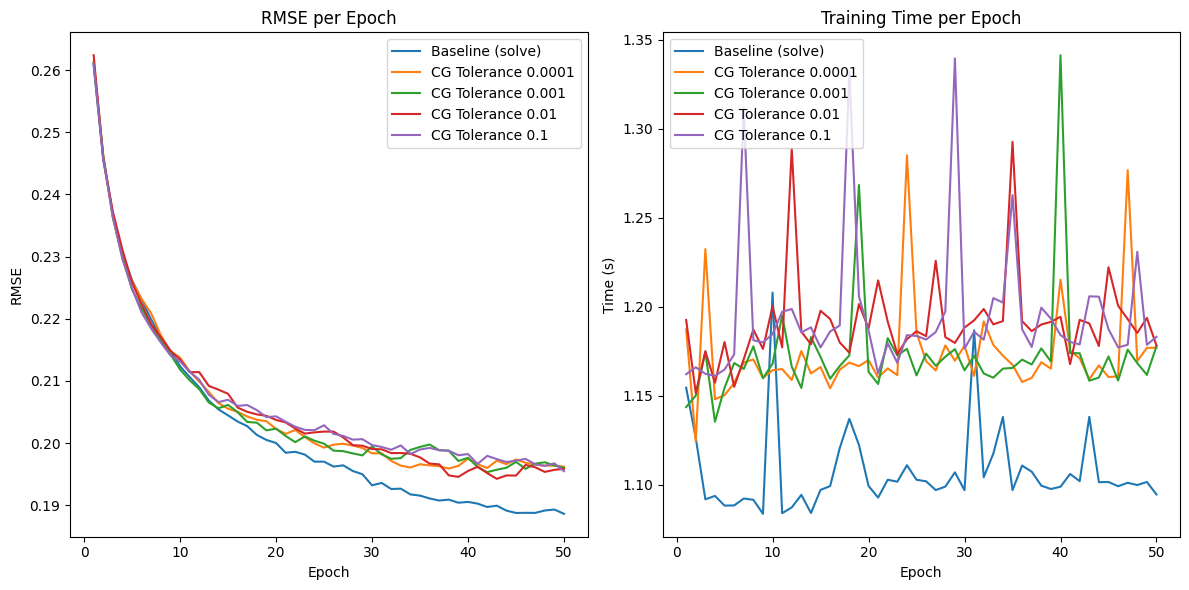

In [29]:
#max iter 50
tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

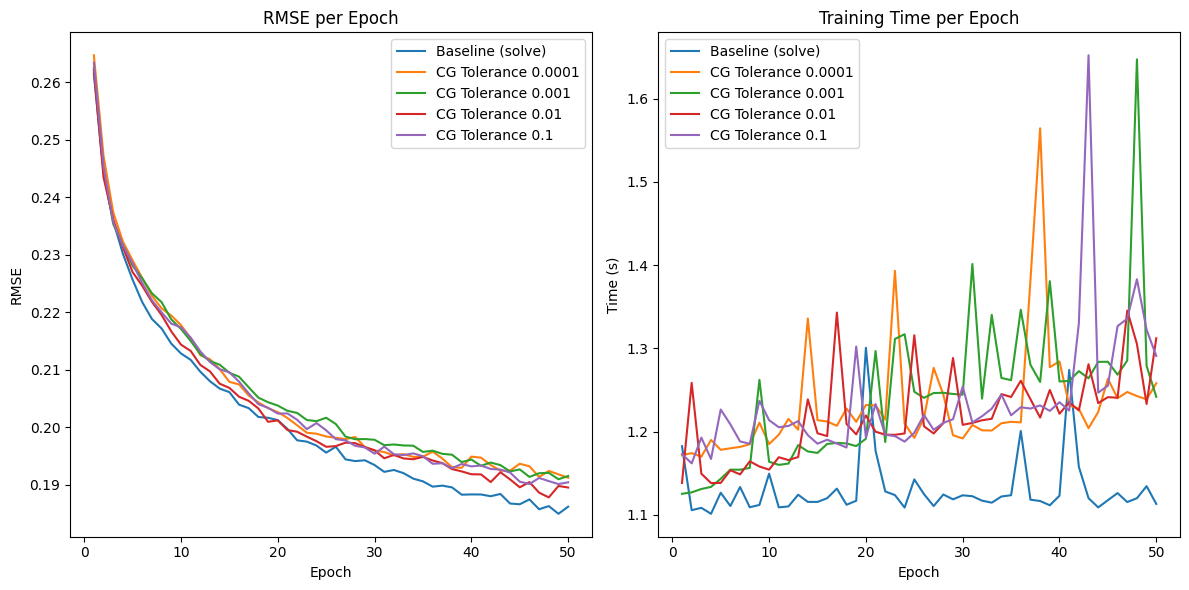

In [32]:
#max iter 1000
tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)